## Libraries and directory

In [1]:
#import packages, there might be some extras
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import keras.utils
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 'large'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip" -d "/content"

Archive:  /content/drive/MyDrive/Progetto_gait_recognition/dataset-20240610T153249Z-001.zip
  inflating: /content/dataset/subject4/lurching/trial1/Sbj4_lurching_T1_P.csv  
  inflating: /content/dataset/subject4/lurching/trial19/Sbj4_lurching_T19_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_P.csv  
  inflating: /content/dataset/subject4/lurching/trial20/Sbj4_lurching_T20_S.csv  
  inflating: /content/dataset/subject4/lurching/trial4/Sbj4_lurching_T4_S.csv  
  inflating: /content/dataset/subject4/lurching/trial10/Sbj4_lurching_T10_S.csv  
  inflating: /content/dataset/subject4/lurching/trial9/Sbj4_lurching_T9_S.csv  
  inflating: /content/dataset/subject4/lurching/trial6/Sbj4_lurching_T6_S.csv  
  inflating: /content/dataset/subject4/lurching/trial17/Sbj4_lurching_T17_S.csv  
  inflating: /content/dataset/subject4/lurching/trial18/Sbj4_lurching_T18_P.csv  
  inflating: /content/dataset/subject4/lurching/trial11/Sbj4_lurching_T11_S.csv  
  inflating: /

In [4]:
if platform.system() == "Darwin":
    root_directory_work = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = '/content'
    root_directory_work = '/content/drive/MyDrive/Progetto_gait_recognition'

print('root directory is ' + root_directory)

root directory is /content


## Train - Validation - Test Split


In [5]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv(root_directory_work +'/reference_document.csv',
                           header=None, names=['Name_file', 'Path_from_Root', 'Type_of_data', 'Type_of_gait', 'Label'])

reference_df = reference_df.iloc[1:]                            # fa iniziare il numero di colonne da 1 al posto che da zero
reference_df['Label'] = reference_df['Label'].astype(int)
reference_df['Subject'] = reference_df['Name_file'].str[:5].str.replace('_', '')

reference_df

,Name_file,Path_from_Root,Type_of_data,Type_of_gait,Label,Subject
1,Sbj9_antalgic_T2_S.csv,subject9/antalgic/trial2/,skeleton,antalgic,0,Sbj9
2,Sbj9_antalgic_T2_P.csv,subject9/antalgic/trial2/,pressure,antalgic,0,Sbj9
3,Sbj9_antalgic_T8_S.csv,subject9/antalgic/trial8/,skeleton,antalgic,0,Sbj9
4,Sbj9_antalgic_T8_P.csv,subject9/antalgic/trial8/,pressure,antalgic,0,Sbj9
5,Sbj9_antalgic_T14_P.csv,subject9/antalgic/trial14/,pressure,antalgic,0,Sbj9
...,...,...,...,...,...,...
2876,Sbj8_normal_T17_S.csv,subject8/normal/trial17/,skeleton,normal,2,Sbj8
2877,Sbj8_normal_T10_P.csv,subject8/normal/trial10/,pressure,normal,2,Sbj8
2878,Sbj8_normal_T10_S.csv,subject8/normal/trial10/,skeleton,normal,2,Sbj8
2879,Sbj8_normal_T6_P.csv,subject8/normal/trial6/,pressure,normal,2,Sbj8


In [6]:
def complete_path(row):
  complete_path = root_directory + '/dataset/' + row['Path_from_Root'] + row['Name_file']
  return complete_path

reference_df['Complete_path'] = reference_df.apply(complete_path, axis=1)
reference_df.set_index('Complete_path', inplace=True)                       # imposta Complete_path come indice per la mia tabella
reference_df = reference_df.drop(columns=['Path_from_Root'])
reference_df

,Name_file,Type_of_data,Type_of_gait,Label,Subject
Complete_path,,,,,
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_S.csv,Sbj9_antalgic_T2_S.csv,skeleton,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,pressure,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_S.csv,Sbj9_antalgic_T8_S.csv,skeleton,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,pressure,antalgic,0,Sbj9
/content/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,pressure,antalgic,0,Sbj9
...,...,...,...,...,...
/content/dataset/subject8/normal/trial17/Sbj8_normal_T17_S.csv,Sbj8_normal_T17_S.csv,skeleton,normal,2,Sbj8
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_P.csv,Sbj8_normal_T10_P.csv,pressure,normal,2,Sbj8
/content/dataset/subject8/normal/trial10/Sbj8_normal_T10_S.csv,Sbj8_normal_T10_S.csv,skeleton,normal,2,Sbj8


In [7]:
# recall
# LABELS = np.array(['antalgic', 'lurching', 'normal', 'steppage', 'stifflegged', 'trendelenburg'])

#split the dataframe into skeleton and pressure, drop the type column

reference_df_s = reference_df[reference_df['Type_of_data']=='skeleton']
reference_df_s = reference_df_s.drop(columns=['Type_of_data', 'Type_of_gait'])

reference_df_p = reference_df[reference_df['Type_of_data']=='pressure']
reference_df_p = reference_df_p.drop(columns=['Type_of_data', 'Type_of_gait'])


# We want to split the data using 10 subjects for training, 1 subject for validation and 1 subject for test
# In this way we are sure that train and test are completely dinstinct

# train_val_test split
train_s = reference_df_s[~reference_df_s['Name_file'].str.startswith('Sbj12')]
test_s = reference_df_s[reference_df_s['Name_file'].str.startswith('Sbj12')]

train_p = reference_df_p[~reference_df_p['Name_file'].str.startswith('Sbj12')]
test_p = reference_df_p[reference_df_p['Name_file'].str.startswith('Sbj12')]

#frequence counts
print("Train Skelly")
print(train_s['Label'].value_counts(), '\n')
print("Test Skelly")
print(test_s['Label'].value_counts(), '\n', '\n')
print("Train Pressure")
print(train_p['Label'].value_counts(), '\n')
print("Test Pressure")
print(test_p['Label'].value_counts())

print(len(train_p))

train_p

Train Skelly
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64 

Test Skelly
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64 
 

Train Pressure
Label
0    220
4    220
5    220
3    220
2    220
1    220
Name: count, dtype: int64 

Test Pressure
Label
5    20
4    20
0    20
3    20
2    20
1    20
Name: count, dtype: int64
1320


,Name_file,Label,Subject
Complete_path,,,
/content/dataset/subject9/antalgic/trial2/Sbj9_antalgic_T2_P.csv,Sbj9_antalgic_T2_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial8/Sbj9_antalgic_T8_P.csv,Sbj9_antalgic_T8_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial14/Sbj9_antalgic_T14_P.csv,Sbj9_antalgic_T14_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial4/Sbj9_antalgic_T4_P.csv,Sbj9_antalgic_T4_P.csv,0,Sbj9
/content/dataset/subject9/antalgic/trial7/Sbj9_antalgic_T7_P.csv,Sbj9_antalgic_T7_P.csv,0,Sbj9
...,...,...,...
/content/dataset/subject8/normal/trial20/Sbj8_normal_T20_P.csv,Sbj8_normal_T20_P.csv,2,Sbj8
/content/dataset/subject8/normal/trial19/Sbj8_normal_T19_P.csv,Sbj8_normal_T19_P.csv,2,Sbj8
/content/dataset/subject8/normal/trial17/Sbj8_normal_T17_P.csv,Sbj8_normal_T17_P.csv,2,Sbj8


## Pressure: load and preprocessing

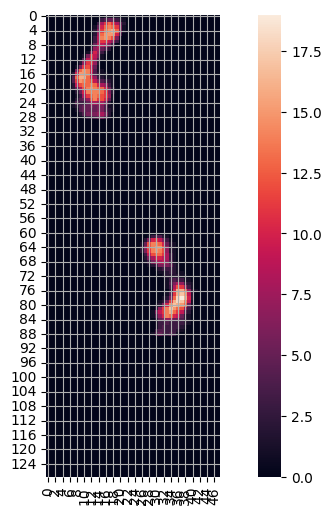

In [8]:
def load_data_ps(complete_path, load=True):

  if load:
    complete_path = complete_path.decode()

  pressure_data = pd.read_csv(complete_path, header=None).to_numpy()

  return pressure_data.squeeze()


# Example
ps_data = load_data_ps(train_p.index[330], load=False)

sns.heatmap(ps_data, square= True)
plt.show()

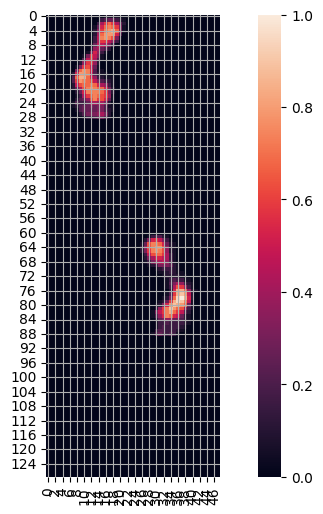

In [9]:
def normalize_data_ps(data):
    massimo = np.max(data)
    data = data / massimo
    return data

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)

sns.heatmap(ps_data_norm, square= True)
plt.show()

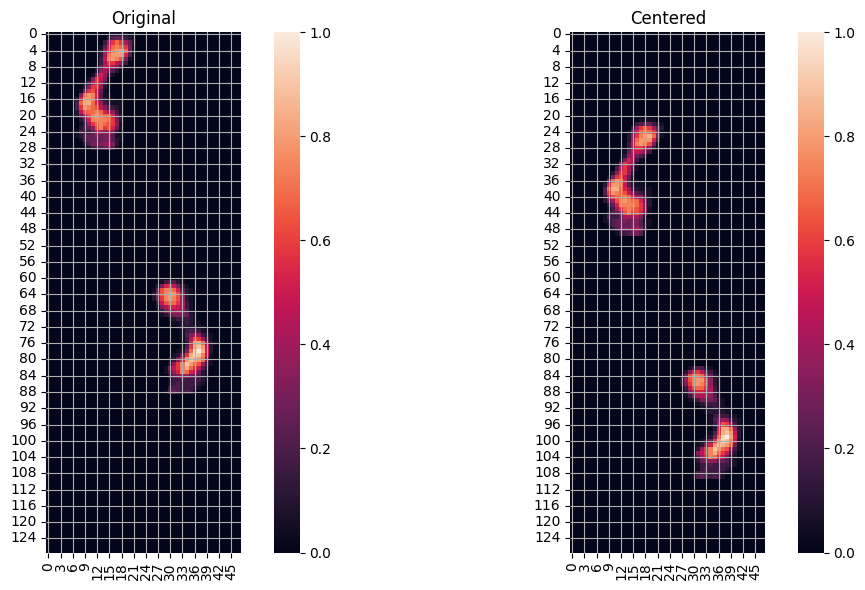

In [10]:
def baricenter(data):
  # Compute the weighted average (barycenter) along each dimension
  y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
  x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

  # print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)
  # print("Center image (x,y) = ", data.shape[1]/2, data.shape[0]/2)

  # Compute the distances between each point and the barycenter
  shift_x = -(x_barycenter - data.shape[1]/2)
  shift_y = -(y_barycenter - data.shape[0]/2)

  # Shift the foot pressure matrix to be centered on the barycenter
  shifted_matrix = np.roll(data, int(shift_x), axis=1)
  shifted_matrix = np.roll(shifted_matrix, int(shift_y), axis=0)

  # y_barycenter_after = np.average(np.arange(shifted_matrix.shape[0]), weights=np.sum(shifted_matrix, axis=1))
  # x_barycenter_after = np.average(np.arange(shifted_matrix.shape[1]), weights=np.sum(shifted_matrix, axis=0))
  # print("Barycenter coordinates (x,y) afetr= ", x_barycenter_after, y_barycenter_after, '\n')

  return shifted_matrix

# Example
ps_data = load_data_ps(train_p.index[330], load=False)
ps_data_norm = normalize_data_ps(ps_data)
cen_ps_data_norm = baricenter(ps_data_norm)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')

# Plot the second heatmap
sns.heatmap(cen_ps_data_norm, square=True,ax=axes[1])
axes[1].set_title('Centered')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

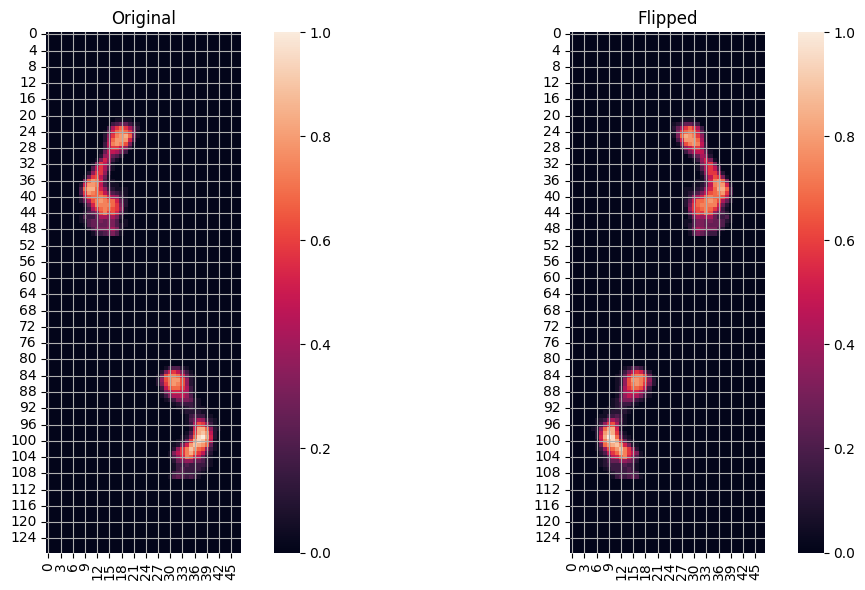

In [11]:
def augment_data(data, flip_rate=0.5):
    a = np.random.rand()

    if a < flip_rate:
        #print("Flip data")
        data = np.flip(data, axis=1)
    return data

cen_ps_data_norm_flip = augment_data(cen_ps_data_norm, flip_rate=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first heatmap
sns.heatmap(cen_ps_data_norm, square=True, ax=axes[0])
axes[0].set_title('Original')

# Plot the second heatmap
sns.heatmap(cen_ps_data_norm_flip, square=True,ax=axes[1])
axes[1].set_title('Flipped')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
def load_prep_ps(complete_path):
    data = load_data_ps(complete_path, load=True)
    data = normalize_data_ps(data)
    data = baricenter(data)

    return data.astype(np.float32)

## Dataset

In [13]:
def create_dataset_ps(table, cache_file, shuffle, batch_size, augmentation, num_sbj, train=False, validation=False, test=False, flip_rate=0.5, repeat=True):

  input_size = (128, 48, 1)

  subject_0 = 'Sbj' + str(num_sbj)
  # subject_1 = 'Sbj' + str(num_sbj+1)

  if num_sbj == 0:
      new_table = table

  else:
      if train:
        new_table = table[table['Subject'] != subject_0]
        # new_table = table[~table['Name_file'].str.startswith(subject_0) & ~table['Name_file'].str.startswith(subject_1)]

      elif validation:
        new_table = table[table['Subject'] == subject_0]
        # new_table = table[table['Name_file'].str.startswith(subject_0) | table['Name_file'].str.startswith(subject_1)]

      elif test:
        new_table = table

      else:
        print("Error, select train, validation or test setting")
        return None

  # print(new_table)

  # Convert dataframe to lists
  file_names = list(new_table.index)
  labels = new_table['Label']

  # Create a Dataset object
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

  # Map the load_and_preprocess_data function
  py_func = lambda path, label: (tf.numpy_function(load_prep_ps, [path], tf.float32), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Cache dataset
  if cache_file:
      dataset = dataset.cache(cache_file)

  # Shuffle
  if shuffle:
      dataset = dataset.shuffle(len(file_names))

  # Map the flip function
  if augmentation:
        py_func = lambda path,label: (tf.numpy_function(augment_data, [path], tf.float32),label)
        dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Repeat the dataset indefinitely
  if repeat:
    dataset = dataset.repeat()

  # Correct input shape for the network
  dataset = dataset.map(lambda img, label: (tf.expand_dims(img, 2), label))

  py_func = lambda img, label: (tf.ensure_shape(img, input_size), label)
  dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

  # Batch
  dataset = dataset.batch(batch_size=batch_size)

  # Prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset

In [ ]:
# batch_p = 60

# sbj = 1
# train_name_file = 'train_p_' + str(sbj)
# val_name_file = 'val_p_' + str(sbj)

# dataset_train_p = create_dataset_ps(table = train_p,
#                                     cache_file = train_name_file,
#                                     shuffle = True,
#                                     batch_size = batch_p,
#                                     augmentation=True,
#                                     num_sbj = sbj,
#                                     train = True)

# dataset_val_p = create_dataset_ps(table = train_p,
#                                     cache_file = val_name_file,
#                                     shuffle = True,
#                                     batch_size = batch_p,
#                                     augmentation=True,
#                                     num_sbj = sbj,
#                                     validation = True)


# train_steps_p = int(np.ceil(1200/batch_p))
# val_steps_p = int(np.ceil(120/batch_p))


# first_element_dataset_p = dataset_train_p.take(1)
# first_element_dataset_p

# for d, l in first_element_dataset_p:
#   print(d.numpy().shape, l.numpy().shape)

(60, 128, 48, 1) (60,)


## CNN model

In [14]:
def ConvPool2d(X, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):

    X = tf.keras.layers.Conv2D(conv_feature_maps, kernel_size=conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    return X

In [15]:
def cls(X, l=0.01):

    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l))(X)
    X = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(l))(X)

    return X

In [16]:
def CNN_p(input_shape, code_size):

    X_input = tf.keras.Input(input_shape)

    # Encoder
    X = ConvPool2d(X_input, conv_feature_maps=16, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=32, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=64, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = ConvPool2d(X, conv_feature_maps=128, conv_kernel=(5, 5), conv_strides=(1, 1), conv_padding='valid', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    X = tf.keras.layers.Flatten()(X)
    X_internal = tf.keras.layers.Dense((code_size))(X)

    X = cls(X_internal, l=0.01)
    X_out = tf.keras.layers.Dense(6, activation='softmax')(X)

    model = tf.keras.Model(inputs = X_input, outputs = X_out, name='CNN_p_classifier')

    return model


input_shape = (128, 48, 1)
internal_code = 100
e_p = CNN_p(input_shape, internal_code)
e_p.summary()

Model: "CNN_p_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 48, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 46, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 46, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 126, 46, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 23, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 21, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 61, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 9, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 29, 9, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 29, 9, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 5, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 1, 128)          │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 11, 1, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 11, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          76,900 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 329,946 (1.26 MB)

 Trainable params: 329,266 (1.26 MB)

 Non-trainable params: 680 (2.66 KB)

## K-fold cross validation

In [17]:
batch_p = 30
lr = 0.0001
train_steps_p = int(np.ceil(1200/batch_p))
val_steps_p = int(np.ceil(120/batch_p))

validation_loss = []
validation_accuracy = []
epochs = []
conf_matrix = np.zeros((6,6))


for i in np.arange(1, 12):

    sbj = i
    train_name_file = 'train_p_' + str(sbj)
    val_name_file = 'val_p_' + str(sbj)

    dataset_train_p = create_dataset_ps(table = train_p,
                                        cache_file = train_name_file,
                                        shuffle = True,
                                        batch_size = batch_p,
                                        augmentation=True,
                                        num_sbj = sbj,
                                        train = True)

    dataset_val_p = create_dataset_ps(table = train_p,
                                        cache_file = val_name_file,
                                        shuffle = True,
                                        batch_size = batch_p,
                                        augmentation=True,
                                        num_sbj = sbj,
                                        validation = True)

    e_p = CNN_p(input_shape, internal_code)

    e_p.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    num_epochs = 350

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=30)

    results = e_p.fit(dataset_train_p,
                      epochs=num_epochs,
                      steps_per_epoch=train_steps_p,
                      validation_data=dataset_val_p,
                      validation_steps=val_steps_p,
                      callbacks=[early_stop_callback],
                      verbose = 0)

    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # validation_loss.append(np.min(val_loss))
    # validation_accuracy.append(np.max(val_accuracy))
    # epochs.append(len(train_accuracy))

    validation_loss.append(np.mean(val_loss[-20:]))
    validation_accuracy.append(np.mean(val_accuracy[-20:]))
    epochs.append(len(val_accuracy))

    print()
    print('-----------------------------------------------------')
    print('Subject out: ', sbj)
    print('Stopped at epoch: ', len(train_accuracy))
    print('Validation loss achived is: ', np.round(np.mean(val_loss[-20:]), 6))
    print('Validation accuracy achived is: ', np.round(np.mean(val_accuracy[-20:]), 6))
    print('-----------------------------------------------------')

    t = np.arange(len(train_accuracy))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()


    dataset_val_p_2 = create_dataset_ps(table = train_p,
                                        cache_file = val_name_file,
                                        shuffle = False,
                                        batch_size = batch_p,
                                        augmentation=False,
                                        num_sbj = sbj,
                                        validation = True,
                                        repeat = False)

    # compute predicted labels
    output_vector = e_p.predict(dataset_val_p_2)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    # extract truth labels
    num_samples_to_extract = 100
    dataset_sample = dataset_val_p_2.take(num_samples_to_extract)

    extracted_labels = []
    for _, label in dataset_sample:
        extracted_labels.extend(label.numpy().tolist())

    true_label = np.array(extracted_labels)

    # compute the error
    e_p.evaluate(dataset_val_p_2)

    # compute the confusion matrix
    cm = confusion_matrix(true_label, predicted_labels)
    conf_matrix = conf_matrix + cm

    print()

    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
                yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
    plt.xticks(rotation=45)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix Training')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

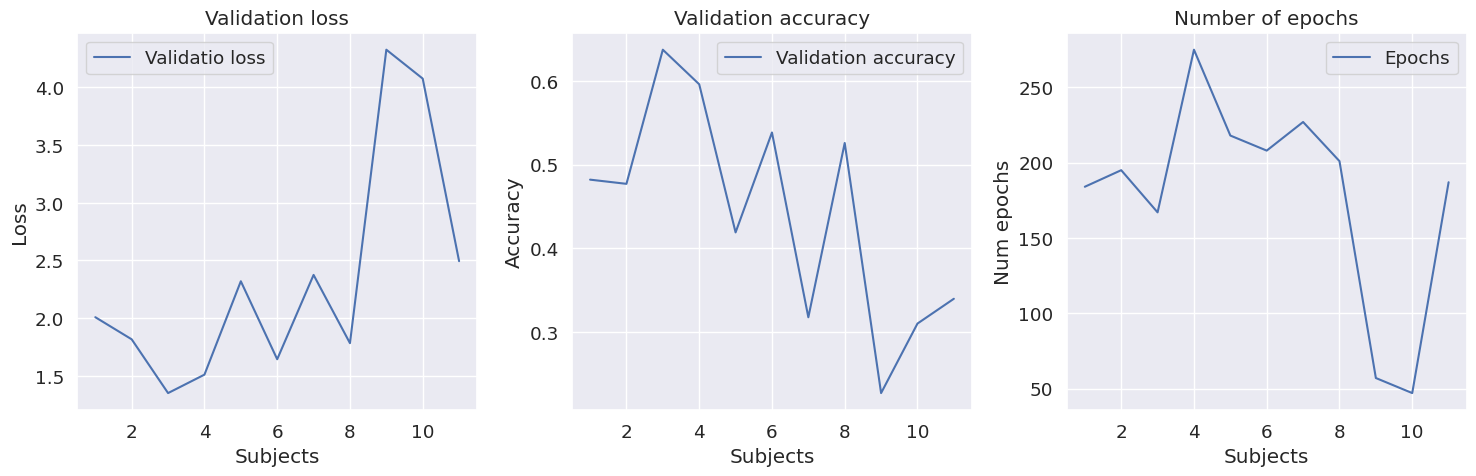


--------------------------------------------------
Internal code size:  100
Batch size:  30
Learnig rate:  0.0001
Average validation loss:  2.336978
Average validation accuracy:  0.442841
--------------------------------------------------


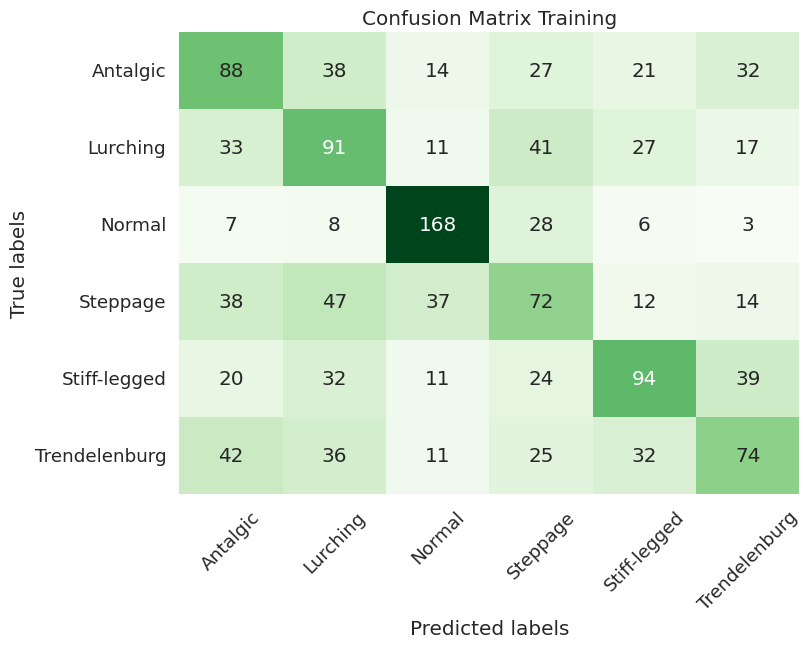

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

s = np.arange(1, 12)

ax1.plot(s, validation_loss, 'b', label='Validatio loss')
ax1.set_title('Validation loss')
ax1.set_xlabel('Subjects')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(s, validation_accuracy, 'b', label='Validation accuracy')
ax2.set_title('Validation accuracy')
ax2.set_xlabel('Subjects')
ax2.set_ylabel('Accuracy')
ax2.legend()

ax3.plot(s, epochs, 'b', label='Epochs')
ax3.set_title('Number of epochs')
ax3.set_xlabel('Subjects')
ax3.set_ylabel('Num epochs')
ax3.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

print()
print('--------------------------------------------------')
print('Internal code size: ', internal_code)
print('Batch size: ', batch_p)
print('Learnig rate: ', lr)
print('Average validation loss: ', np.round(np.mean(validation_loss), 6))
print('Average validation accuracy: ', np.round(np.mean(validation_accuracy), 6))
print('--------------------------------------------------')

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap="Greens", cbar=False,
            xticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'],
            yticklabels=['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg'])
plt.xticks(rotation=45)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Training')
plt.show()

In [19]:
def class_specific_metrics(cm, class_labels = ['Antalgic', 'Lurching', 'Normal', 'Steppage', 'Stiff-legged', 'Trendelenburg']):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [20]:
df = class_specific_metrics(conf_matrix)
df

,Accuracy,Sensitivity,Specificity,Precision
Antalgic,0.793939,0.400000,0.872727,0.385965
Lurching,0.780303,0.413636,0.853636,0.361111
Normal,0.896970,0.763636,0.923636,0.666667
Steppage,0.778030,0.327273,0.868182,0.331797
Stiff-legged,0.830303,0.427273,0.910909,0.489583
Trendelenburg,0.809848,0.336364,0.904545,0.413408
